In [2]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [3]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_cars_drop_checkpoints_with_nms'

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

In [4]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
idd_data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"

kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val')

# Full datasets samples
kitti_train_samples = len(kitti_train_dataset)
kitti_val_samples = len(kitti_val_dataset)
idd_val_samples = len(idd_val_dataset)

# Subset Datasets
subset_kitti_train_samples = round(len(kitti_train_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_kitti_val_samples = round(len(kitti_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)
subset_idd_val_samples = round(len(idd_val_dataset) * SUBSET_SAMPLE_DATA_PERCENTAGE)

SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

# Subset of full datasets
subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

In [5]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model

In [6]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11060017_0.7454640828611436  fasterrcnn_11061638_0.7497252402944325
fasterrcnn_11061427_0.7282598515502949  fasterrcnn_11061705_0.7526206908232453
fasterrcnn_11061454_0.733123502219126   fasterrcnn_11062316_0.7550167879591324
fasterrcnn_11061507_0.7394557961451338


In [7]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# Extract classifier features

In [8]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [9]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_detections = len(all_max_ious)
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    print("Total detections: %d" % (total_detections))
    print("Total false positives (< %.2f) IoU: %f%%" % (MIN_IOU_REQUIRED, float(total_false_positives)/float(total_detections)*100))
    

def read_features(save_file, feature_idx, start=0, end=None):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y


def read_scores(save_file, start=0, end=None):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y

# Extract classifier features

#### Kitti Train

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


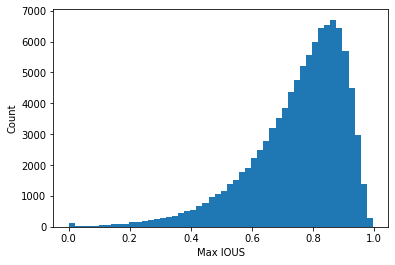

Total false positives (< 0.70) IoU: 30097
Total detections: 100161
Total false positives (< 0.70) IoU: 30.048622%


In [9]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val

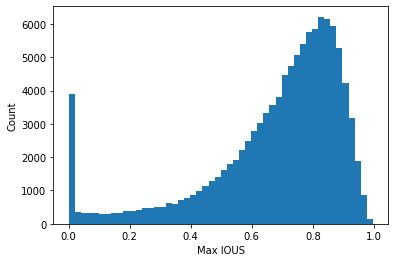

Total false positives (< 0.70) IoU: 44992
Total detections: 109653
Total false positives (< 0.70) IoU: 41.031253%


In [10]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


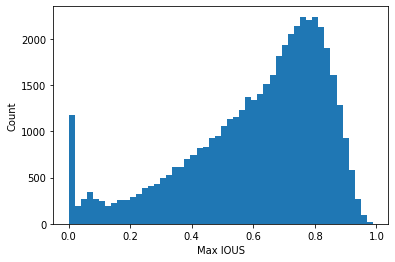

Total false positives (< 0.70) IoU: 26910
Total detections: 47814
Total false positives (< 0.70) IoU: 56.280587%


In [79]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

# Max Softmax

#### Kitti train

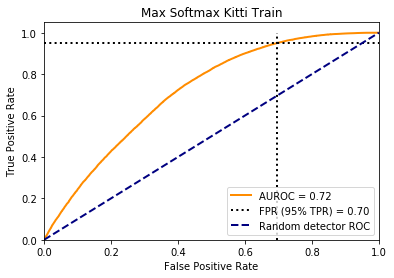

{'fpr_at_95_tpr': 0.6959027896811792, 'detection_error': 0.37288797038543037, 'auroc': 0.7155497132415031, 'aupr_in': 0.46662854772554396, 'aupr_out': 0.8635484557437986}


In [11]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_scores(save_path)

kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Max Softmax Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

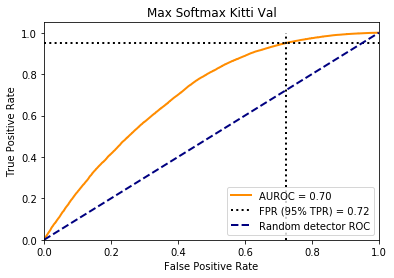

{'fpr_at_95_tpr': 0.7218035747649001, 'detection_error': 0.3858990355937874, 'auroc': 0.7048852459398478, 'aupr_in': 0.5775993174825218, 'aupr_out': 0.7873338031605592}


In [12]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Max Softmax Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

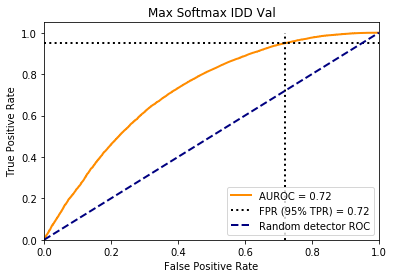

{'fpr_at_95_tpr': 0.721027098544617, 'detection_error': 0.38549517840997616, 'auroc': 0.7208639591329257, 'aupr_in': 0.7362681725421387, 'aupr_out': 0.6900093004139481}


In [80]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Max Softmax IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## One-Class SVM on Kitti features (Conv-512 layer)

In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 0)

In [14]:
kitti_train_X.shape

(100161, 512)

In [83]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    
if False:
    training_mask = kitti_train_y.astype(np.bool)

    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])
    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

#### Kitti Train

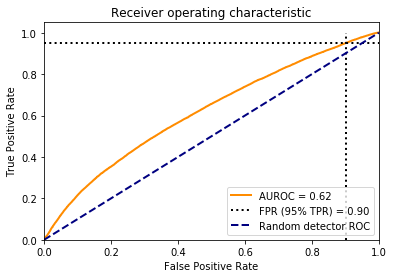

{'fpr_at_95_tpr': 0.9011242662421649, 'detection_error': 0.4755342989867207, 'auroc': 0.6170847806382096, 'aupr_in': 0.7812818050201896, 'aupr_out': 0.39620990765567105}


In [16]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [17]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 0)

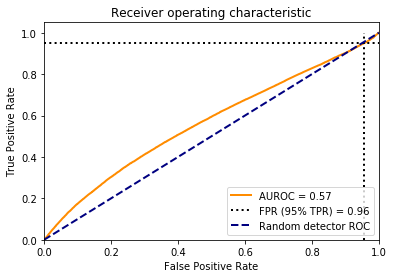

{'fpr_at_95_tpr': 0.9557644468904787, 'detection_error': 0.499755130568319, 'auroc': 0.5653726136412283, 'aupr_in': 0.6494756767528453, 'aupr_out': 0.4459515783092815}


In [18]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [84]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 0)

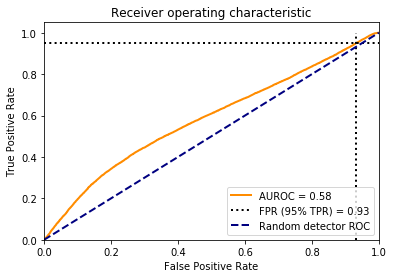

{'fpr_at_95_tpr': 0.9319516911737877, 'detection_error': 0.49093651081936246, 'auroc': 0.5840621094517212, 'aupr_in': 0.5133740475918346, 'aupr_out': 0.6292337929445481}


In [85]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [19]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 1)

In [20]:
kitti_train_X.shape

(100161, 4096)

In [86]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    
if False:
    training_mask = kitti_train_y.astype(np.bool)
    print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)
    
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

#### Kitti Train

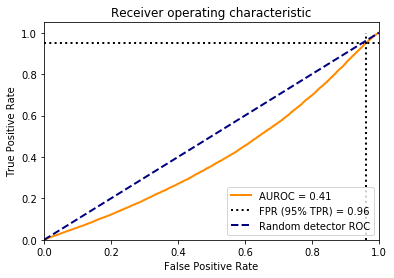

{'fpr_at_95_tpr': 0.96186117467582, 'detection_error': 0.49968462606220787, 'auroc': 0.4069216423543474, 'aupr_in': 0.6416756424670366, 'aupr_out': 0.25622354101787664}


In [22]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [23]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 1)

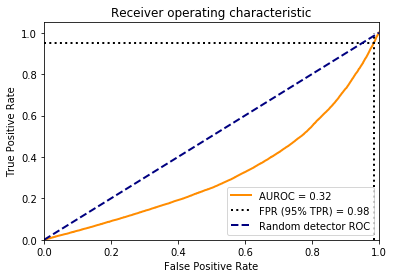

{'fpr_at_95_tpr': 0.9843258117776554, 'detection_error': 0.5, 'auroc': 0.3217025851321015, 'aupr_in': 0.47916317227232347, 'aupr_out': 0.31202778397609443}


In [24]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [87]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 1)

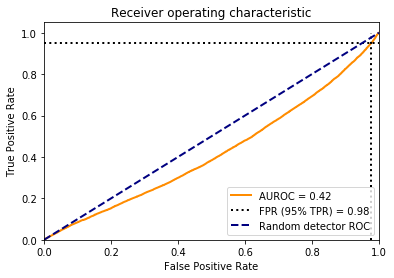

{'fpr_at_95_tpr': 0.9770131718174189, 'detection_error': 0.4999515273388571, 'auroc': 0.4216396901376398, 'aupr_in': 0.38509323898259884, 'aupr_out': 0.5113847049741483}


In [88]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

# Mahalanobis

#### Kitti train

In [25]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 4)

In [26]:
kitti_train_X.shape

(100161, 4096)

In [89]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")

if False:
    # Take features from good detections only
    kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]
    
    # Everything is labelled 0 because we're just doing single class detection
    kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))
    
    md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
    md.save(mahal_model_name)
    
else:
    md = Mahal_Dist.load(mahal_model_name)

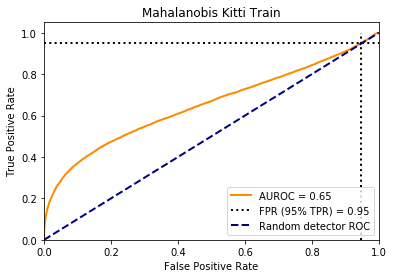

{'fpr_at_95_tpr': 0.9467716189578333, 'detection_error': 0.4975451545535095, 'auroc': 0.6522653587850024, 'aupr_in': 0.5511250858798082, 'aupr_out': 0.7638600021742583}


In [57]:
# Chunked MD calc
l = len(kitti_train_X)
chunk = 10000
kitti_train_novelty_scores = [md(kitti_train_X[i:i+chunk]) for i in range(0,l,chunk_size)]
kitti_train_novelty_scores = np.concatenate(kitti_train_novelty_scores, axis=0)

# Non-chunked version for smaller datasets
# kitti_train_novelty_scores = md(kitti_train_X)

plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Mahalanobis Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

In [ ]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



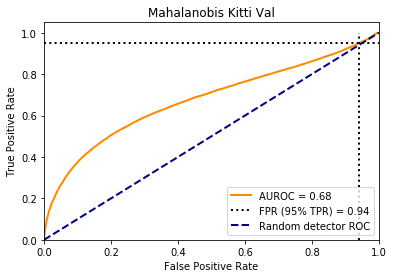

{'fpr_at_95_tpr': 0.9418010836395342, 'detection_error': 0.49588624047058005, 'auroc': 0.6767289933574218, 'aupr_in': 0.6487890462019605, 'aupr_out': 0.6844329841073483}


In [60]:
# Chunked MD calc
l = len(kitti_val_X)
chunk = 10000
kitti_val_novelty_scores = [md(kitti_val_X[i:i+chunk]) for i in range(0,l,chunk_size)]
kitti_val_novelty_scores = np.concatenate(kitti_val_novelty_scores, axis=0)

# Non-chunked version for smaller datasets
# kitti_val_novelty_scores = md(kitti_val_X)

plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

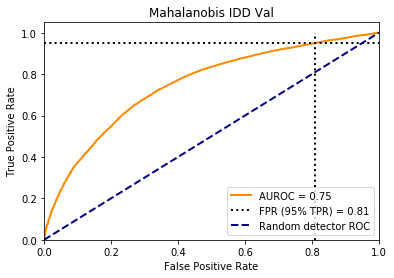

{'fpr_at_95_tpr': 0.8094771401969912, 'detection_error': 0.4297321848684449, 'auroc': 0.7485611890772801, 'aupr_in': 0.7894466596396695, 'aupr_out': 0.661384498437345}


In [23]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_y = []

# Chunked MD calc
with h5py.File(save_path, 'r') as f:
    l = (len(f))

chunk = 1000

idd_val_novelty_scores = []
for i in range(0, l, chunk):
    X, y = read_features(save_path, 4, i, i+chunk)
    idd_val_novelty_scores.append(md(X))
    idd_val_y.append(y)

idd_val_novelty_scores = np.concatenate(idd_val_novelty_scores, axis=0)
idd_val_y = np.concatenate(idd_val_y, axis=0)

# Non-chunked version for smaller datasets
# idd_val_novelty_scores = md(idd_val_X)

plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Mahalanobis IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## ODIN

### Find best params

In [93]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
# temperatures = np.array([1])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.linspace(0, 0.004, 5)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

In [94]:
results = []

trainer.faster_rcnn.eval()
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    if False:# and not os.path.exists(save_file):
        extract_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
    kitti_val_X, kitti_val_y = read_scores(save_file)
    kitti_val_novelty_scores = -kitti_val_X
    results.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

ODIN Kitti Val e=0.000000, T=1000



ODIN Kitti Val e=0.000200, T=1000



ODIN Kitti Val e=0.000400, T=1000



ODIN Kitti Val e=0.000600, T=1000



ODIN Kitti Val e=0.000800, T=1000



ODIN Kitti Val e=0.001000, T=1000



ODIN Kitti Val e=0.001200, T=1000



ODIN Kitti Val e=0.001400, T=1000



ODIN Kitti Val e=0.001600, T=1000



ODIN Kitti Val e=0.001800, T=1000



ODIN Kitti Val e=0.002000, T=1000



ODIN Kitti Val e=0.002200, T=1000



ODIN Kitti Val e=0.002400, T=1000



ODIN Kitti Val e=0.002600, T=1000



ODIN Kitti Val e=0.002800, T=1000



ODIN Kitti Val e=0.003000, T=1000



ODIN Kitti Val e=0.003200, T=1000



ODIN Kitti Val e=0.003400, T=1000



ODIN Kitti Val e=0.003600, T=1000



ODIN Kitti Val e=0.003800, T=1000



ODIN Kitti Val e=0.004000, T=1000


In [95]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results[1:]])
print("Best params:", odin_params[1:][best_params])

eps, temp = odin_params[1:][best_params]

Best params: (0.0022, 1000)


### Calc results for data using found params

#### Kitti train

--- Logging error ---
Traceback (most recent call last):
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/li

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tadenou

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/popen_fork.py", line 74, in _launch
    code = process_obj._bootstrap()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 290, in _bootstrap
    util._run_after_forkers()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/util.py", line 128, in _run_after_forkers
    items = list(_afterfork_registry.items())
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/weakref.py", line 217, in items
    yield k, v
  File "/ho

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '9baea56c-7a9aea9f746e6c6f94adcfe9', 'msg_type': 'comm_msg', 'username': 'tadenoud', 'session': '39c835b6-82e0315468f162e7be673a61', 'date': datetime.datetime(2019, 12, 16, 22, 4, 26, 658248, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '9baea56c-7a9aea9f746e6c6f94adcfe9', 'msg_type': 'comm_msg', 'parent_header': {'msg_id': '63b00a9efe94480a836cd80e6b9357a8', 'username': 'username', 'session': 'da51fafc1b914aaa850e650961655943', 'msg_type': 'execute_request', 'version': '5.2', 'date': datetime.datetime(2019, 12, 16, 22, 4, 26, 358301, tzinfo=datetime.timezone.utc)}, 'content': {'data': {'method': 'u

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yi

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, res

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img, bbox, label, difficult = self.db.get_example(idx)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactive

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/data/dataset.py", line 138, in __getitem__
    ori_img,

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 41, in <module>
    from . import Image, ImageFile, TiffImagePlugin
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File 

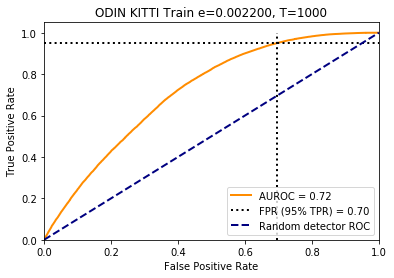

{'fpr_at_95_tpr': 0.6959498730390126, 'detection_error': 0.37295348697938335, 'auroc': 0.7155589856238814, 'aupr_in': 0.46701642982010577, 'aupr_out': 0.8636162597192281}


In [68]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:# and not os.path.exists(save_file):
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)

kitti_train_X, kitti_train_y = read_scores(save_file)
kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="ODIN KITTI Train e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val


ODIN Kitti Val e=0.002200, T=1000


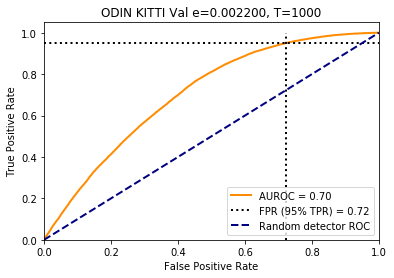

{'fpr_at_95_tpr': 0.7221980710201156, 'detection_error': 0.3860885521145636, 'auroc': 0.7044166218627668, 'aupr_in': 0.5760209970505181, 'aupr_out': 0.7874982594339509}


In [69]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False:# and not os.path.exists(save_file):
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))
kitti_val_X, kitti_val_y = read_scores(save_file)
kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="ODIN KITTI Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:


--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform

--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
  File "/home/tadenoud/Git/simple-faster-rcnn-pytorch/utils/idd_utils.py", line 112, in read_image
    f = Image.open(path)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
--- Logging error ---
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  Fi

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
Call stack:
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/asyncio/ba

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "<ipython-input-96-f531642981ab>", line 4, in <module>
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, e

  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tadenoud/Git/simple-faster-rcnn

  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
BrokenPipeError: [Errno 32] Broken pipe
Call stack:
  File "<frozen importlib._bootstrap_external>", line 72

  File "<frozen importlib._bootstrap_external>", line 857, in get_code
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 121, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "<frozen importlib._bootstrap_external>", line 525, in _compile_bytecode
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/tqdm/std.py", line 1039, in __del__
    self.clo

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 2781, in open
    preinit()
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/PIL/Image.py", line 381, in preinit
    from . import BmpImagePlugin
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "<frozen importlib._bootstrap>", line 677, in _load_unlock

  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-f531642981ab>", line 4, in <module>
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
  File "<ipython-input-8-ef4a010a3feb>", line 58, in extract_idd_features
    for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerat

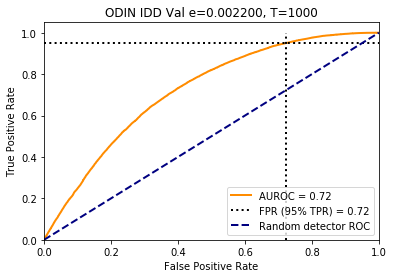

{'fpr_at_95_tpr': 0.7217650243638332, 'detection_error': 0.38588806697711764, 'auroc': 0.7202675922784352, 'aupr_in': 0.7345070743725448, 'aupr_out': 0.6904197083866157}


In [96]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if True:# and not os.path.exists(save_file):
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

idd_val_X, idd_val_y = read_scores(save_file)
idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## Entropy

In [9]:
NUM_MC_PASSES = 10

def extract_kitti_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    model.train()
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()
      
        
def extract_idd_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()

#### Kitti Val

In [71]:
if False:
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
    extract_kitti_mc_softmax(kitti_val_dataset, trainer.faster_rcnn, save_file)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
import mc_uncertainty as mcu


def read_mc_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]

            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=-1)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return np.moveaxis(np.stack((X, 1-X)), 0, 2), y

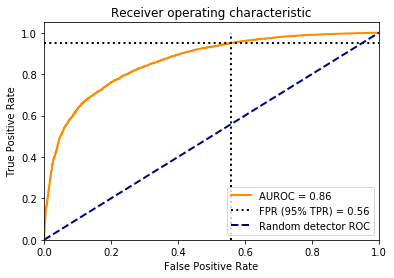

{'fpr_at_95_tpr': 0.5576923076923077, 'detection_error': 0.30383359734188464, 'auroc': 0.8628160743492235, 'aupr_in': 0.8982402214760286, 'aupr_out': 0.8072416360709921}


In [73]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

In [11]:
if False:
    save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
    extract_idd_mc_softmax(idd_val_dataset, trainer.faster_rcnn, save_file)

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)



(10, 8878, 2)


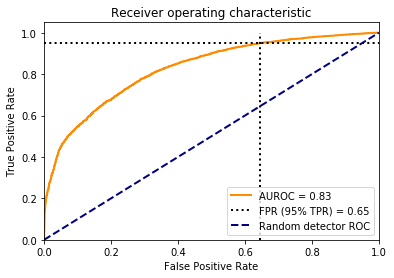

{'fpr_at_95_tpr': 0.6460344104070499, 'detection_error': 0.3479442480050814, 'auroc': 0.8274432905502825, 'aupr_in': 0.8198573114054868, 'aupr_out': 0.8312472708391049}


In [26]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)
print(X.shape)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

## Mutual Information

#### Kitti Val

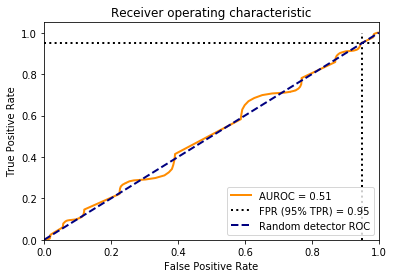

{'fpr_at_95_tpr': 0.9485221978021977, 'detection_error': 0.49586550650086564, 'auroc': 0.505731308286557, 'aupr_in': 0.5977703924388346, 'aupr_out': 0.414163401580222}


In [74]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

#### IDD Val

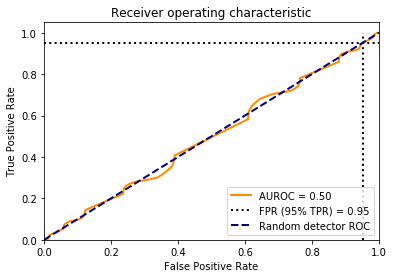

{'fpr_at_95_tpr': 0.9528211192919543, 'detection_error': 0.49758227865669763, 'auroc': 0.4984662047642918, 'aupr_in': 0.4636930558967389, 'aupr_out': 0.5358700688836592}


In [11]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

# Vahdats Extended Feature Extractor Set

### Bind a feature extractor function to the model

In [10]:
model = trainer.faster_rcnn

@nograd
def get_all_features(self, imgs, visualize=False):
    self.eval()
    if visualize:
        prepared_imgs = list()
        for img in imgs:
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
    else:
         prepared_imgs = imgs 

    for img in prepared_imgs:
        img = at.totensor(img[None], cuda=True).float()
        features = [img]
        
        for l in self.extractor:
            features.append(l(features[-1]))
        
        # Detach all features from GPU
        features = [at.tonumpy(f) for f in features]
        # Remove the first feature (ie the image)
        features = features[1:]
        # Average the features over the final two dimensions
        features = [np.mean(f, axis=(2,3)).squeeze(axis=0) for f in features]
        return features
    
model.get_all_features = get_all_features.__get__(model)

### Get the GT features

In [ ]:
def extract_extended_kitti_features_gt(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            cars_bboxes = gt_bboxes[gt_labels == 0]
            
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(cars_bboxes):
                d_car = d.create_group("gt_bbox_"+str(j))
                y1, x1, y2, x2 = box.type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]
                
                # Check correct sections of image are extracted
                # plt.imshow(np.moveaxis(np.squeeze(at.tonumpy(im), axis=0), 0, 2).astype(np.int))
                # plt.show()
                
                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_car.create_dataset("extended_feat_"+str(k), data=feats)

if True:
    extract_extended_kitti_features_gt(kitti_train_dataset, trainer.faster_rcnn, os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5"))

In [ ]:
def extract_extended_kitti_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
                    
def extract_extended_idd_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

if False:
    save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(subset_kitti_val_dataset, trainer.faster_rcnn, save_path)

if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

if False:
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    extract_extended_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


### Train SVM classifiers

In [ ]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
SUBSET_KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

def read_gt_extended_features(file, feature_idx):
    features = None
    
    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            for gt_bbox in im.keys():
                gt_bbox = im[gt_bbox]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features


def read_extended_features(file, feature_idx):
    features = None
    labels = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            # Get the correctness labels
            label_is_car = im['pred']["pred_labels"][()] == 0
            iou_is_high_enough = im['pred']["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            labs = 1 - (label_is_car & iou_is_high_enough & classification_is_correct)
            labels = np.concatenate((labels, labs), axis=0)

            # Get the required features
            for j in im['bboxes'].keys():
                gt_bbox = im['bboxes'][j]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features, labels

# Train all the classifiers
def train_osvm(nu, gamma, kernel, train_features, one_class_save_path):
        # Train one class SVM
        clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        clf.fit(train_features)

        # Save classifier
        with open(one_class_save_path, 'wb') as f:
            pickle.dump(clf, f)

NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

if True:
    for i in trange(NUM_EXTENDED_FEATURES):
        features_gt = read_gt_extended_features(GT_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            train_osvm(nu, gamma, kernel, features_gt, save_path)

### Determine best params/OODL

In [ ]:
if True:
    kitti_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):

        # Load the kitti val features
        kitti_val_X, kitti_val_y = read_extended_features(SUBSET_KITTI_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/subset_kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
            res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            kitti_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'wb') as f:
        pickle.dump(kitti_val_results, f)

else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

In [ ]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])

print(best_params)
print(kitti_val_results[best_params])

In [ ]:
oodl, (nu, gamma, kernel) = list(itertools.product(list(range(NUM_EXTENDED_FEATURES)), train_args))[best_params]

In [ ]:
# Load the best classifier
save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
with open(save_path, 'rb') as f:
    clf = pickle.load(f)

### Kitti Val

In [ ]:
kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

### IDD VAL

In [ ]:
idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, oodl)

# Calculate performance metrics
idd_val_novelty_scores = -clf.decision_function(idd_val_X)
res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

res['nu'] = nu
res['gamma'] = gamma
res['kernel'] = kernel
res['features'] = oodl
res['model'] = save_path

print(res)

### TODO:

#### Code

1. Train multiple class model
    1. Different anchor boxes
    - Scale == 1500?
    - See "A closer look at Faster R-CNN for vehicle detection"
1. Example images of poor detections


1. Repeat all experiments with multiple class object detector

1. Risk-Coverage plots
1. AP with each method
1. Runtime statistics for a single prediction for each method

1. Rerun experiments for False positive detection

1. More correct Mahalanobis with input perturbation?


#### Other stuff

1. Remove Steve as co-supervisor
1. Email grad director for two-week display period
1. Agreement to read form

#### Writing

1. Finish results
1. Finish experimental setup
1. Write conclusion/discussion
1. Add more background on AnDet techniques
1. Rewrite intro sections
1. Edit edit edit

## Mahalanobis with input perturbation

In [ ]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.

# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])

epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.array([0.0034])

odin_params = list(itertools.product(epsilons, temperatures))

Build a Mahalanobis model for each of train eps and temp

In [ ]:
if False:
    for eps, temp in tqdm(odin_params, total=len(odin_params)):
        save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp))
        kitti_train_X, kitti_train_y = read_features(save_file, 4)

        mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    
        # Take features from good detections only
        kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]

        # Everything is labelled 0 because we're just doing single class detection
        kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))

        md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
        md.save(mahal_model_name)

Get the best model based on the Kitti Val performance

In [ ]:
results2 = []
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    # Get the data
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
    kitti_val_X, kitti_val_y = read_features(save_path, 4)
    
    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)
    
    kitti_val_novelty_scores = md(kitti_val_X)
    results2.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

In [ ]:
# Pick the best eps and temp

idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
print(odin_params[1:][idx])

eps, temp = odin_params[1:][idx]

# Load the model
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
md = Mahal_Dist.load(mahal_model_name)

#### Kitti Val

In [ ]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
kitti_val_X, kitti_val_y = read_features(save_path, 4)

kitti_val_novelty_scores = md(kitti_val_X)
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD Val

In [ ]:
# Get the data
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
idd_val_X, idd_val_y = read_features(save_path, 4)

idd_val_novelty_scores = md(idd_val_X)
plot_roc(idd_val_novelty_scores, 1 - idd_val_y)
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))